## Классификация предметов одежды (датасет Fashion MNIST)


#### Загрузка датасета

In [ ]:
batch_size = 64
lr = 0.001
epochs = 10


normalize = transforms.Lambda(lambda x: x / 255.)

transform = transforms.Compose([transforms.ToTensor(), normalize]) # композиция преобразований - тензоры -> нормализация

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # объект загрузки данных
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.3MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 308kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.55MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.21MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Выведем изображения с метками:

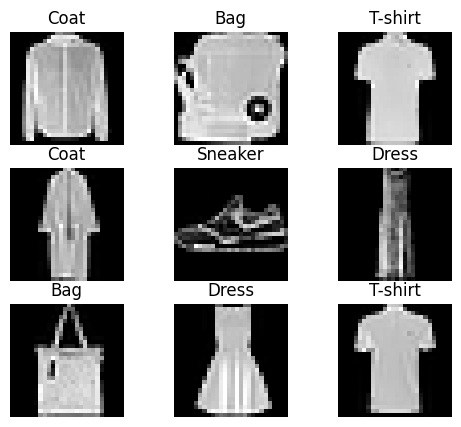

In [ ]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (6,5))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_dataset), size = (1,)).item()
    image, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

Посмотрим на размер одного батча:

Размер X в виде [N, C, H, W]: torch.Size([64, 1, 28, 28])
Размер y: torch.Size([64]) <built-in method type of Tensor object at 0x7d26fabe4270>



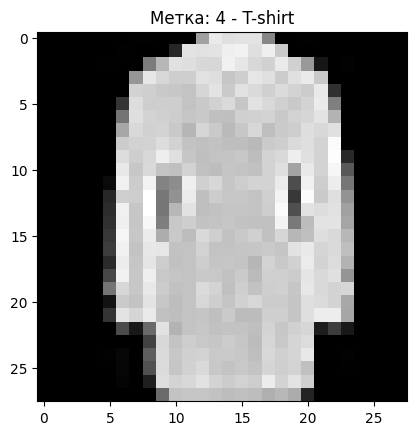


Размер массива меток: torch.Size([64])


In [ ]:
for X, y in train_loader:
    train_features, train_labels = next(iter(train_loader)) # получение первых элементов
    print(f'Размер X в виде [N, C, H, W]: {X.shape}')
    print(f'Размер y: {y.shape} {y.type}\n')

    image = train_features[0].squeeze() # первое изображение
    label = train_labels[0]             # первая метка
    sample_idx= torch.randint((label), size = (1,)).item()  # случайный индекс для отображения

    plt.title(f"Метка: {label} - {labels_map[sample_idx]}")
    plt.imshow(image, cmap="gray")
    plt.show()
    print(f"\nРазмер массива меток: {train_labels.size()}")
    break

In [ ]:
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),  # Входной слой -> Скрытый слой 1
            nn.ReLU(),
            nn.Linear(512, 256),  # Скрытый слой 1 -> Скрытый слой 2
            nn.ReLU(),
            nn.Linear(256, 10)  # Скрытый слой 2 -> Выходной слой (10 классов)
        )

    def forward(self, x):
        x = x.view(-1, 28*28)  # преобразуем изображение 28x28 в вектор 784
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = self.fc3(x)
        x = self.linear_relu_stack(x)
        return x

####  Архитектура модели для решения задачи

In [ ]:
class CNNFashionMNIST(nn.Module):
    def __init__(self):
        super(CNNFashionMNIST, self).__init__()

        # сверточные слои
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # полносвязные слои
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # прохождение через сверточные слои с активацией и пулингом
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # преобразуем тензор для полносвязных слоев
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
train_size = int(0.8 * len(train_dataset))  # 80% для тренировки
val_size = len(train_dataset) - train_size  # 20% для валидации
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
train_size

48000

#### Обучение модели

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, mean_absolute_error
import seaborn as sns

train_losses, val_losses = [], []
train_labels, train_preds = [], []
val_labels, val_preds = [], []

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        epoch_loss_train = 0.0
        correct_train = 0
        total_train = 0

        correct_val = 0
        total_val = 0


        start_time = time.time()

        model.train()
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False):
            optimizer.zero_grad()
            y_pred = model(images)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()

            epoch_loss_train += loss.item()

            _, predicted = torch.max(y_pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            train_labels.extend(labels.cpu().numpy())
            train_preds.extend(predicted.cpu().numpy())

        model.eval()
        epoch_loss_val = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                y_pred = model(images)
                loss = criterion(y_pred, labels)
                epoch_loss_val += loss.item()

                _, predicted = torch.max(y_pred.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(predicted.cpu().numpy())


        accuracy_train = 100 * correct_train / total_train
        accuracy_val = 100 * correct_val / total_val

        f1_train = f1_score(train_labels, train_preds, average='weighted')
        f1_val = f1_score(val_labels, val_preds, average='weighted')

        mae_train = mean_absolute_error(train_labels, train_preds)
        mae_val = mean_absolute_error(val_labels, val_preds)

        elapsed_time = time.time() - start_time

        epoch_loss_train = epoch_loss_train/ len(train_loader)
        epoch_loss_val = epoch_loss_val/ len(val_loader)

        train_losses.append(epoch_loss_train)
        val_losses.append(epoch_loss_val)


        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss_train:.4f}, Val Loss: {epoch_loss_val:.4f},\n '
              f'Train Acc: {accuracy_train:.2f}%, Val Acc: {accuracy_val:.2f}%,\n '
              f'Train F1: {f1_train:.2f}, Val F1: {f1_val:.2f},\n '
              f'Train MAE: {mae_train:.4f}, Val MAE: {mae_val:.4f}, Time: {elapsed_time:.2f}s\n\n')

    #return train_losses, val_losses, val_labels, val_preds


In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

Epoch [1/5], Train Loss: 0.5755, Val Loss: 0.5521,
 Train Acc: 78.64%, Val Acc: 80.17%,
 Train F1: 0.78, Val F1: 0.80,
 Train MAE: 0.6617, Val MAE: 0.6132, Time: 77.74s




Epoch [2/5], Train Loss: 0.5369, Val Loss: 0.5164,
 Train Acc: 80.22%, Val Acc: 81.10%,
 Train F1: 0.79, Val F1: 0.80,
 Train MAE: 0.6424, Val MAE: 0.6072, Time: 79.91s




Epoch [3/5], Train Loss: 0.5070, Val Loss: 0.4941,
 Train Acc: 81.34%, Val Acc: 81.95%,
 Train F1: 0.80, Val F1: 0.81,
 Train MAE: 0.6243, Val MAE: 0.6010, Time: 78.56s




Epoch [4/5], Train Loss: 0.4759, Val Loss: 0.4628,
 Train Acc: 82.83%, Val Acc: 83.19%,
 Train F1: 0.80, Val F1: 0.81,
 Train MAE: 0.6051, Val MAE: 0.5828, Time: 79.70s




Epoch [5/5], Train Loss: 0.4536, Val Loss: 0.4487,
 Train Acc: 83.64%, Val Acc: 83.83%,
 Train F1: 0.81, Val F1: 0.82,
 Train MAE: 0.5886, Val MAE: 0.5661, Time: 78.98s




#### График функции потерь по эпохам

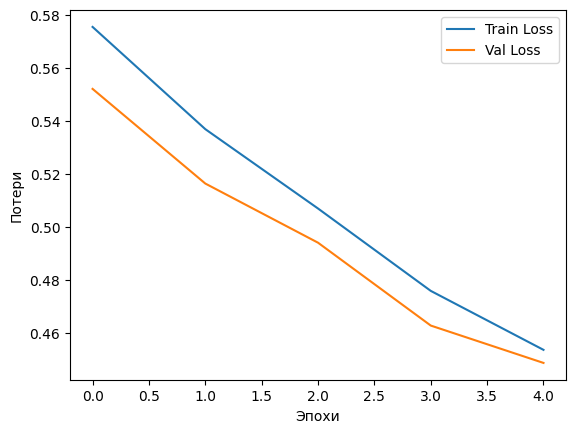

In [ ]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Эпохи')
    plt.ylabel('Потери')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)

#### Матрица ошибок и значение accuracy на тестовом множестве

Accuracy на тестовом множестве: 83.03%



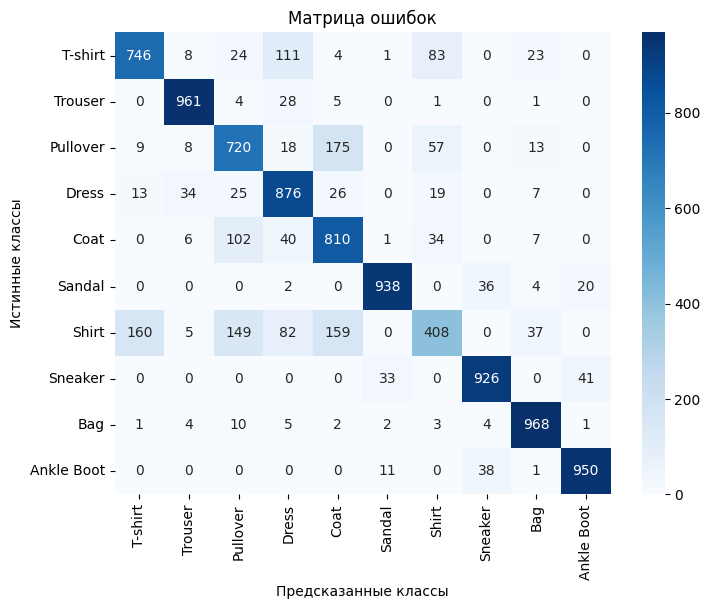

In [ ]:
# Оценка модели и вычисление точности
def evaluate_model(model, test_loader):
    model.eval()  # Переводим модель в режим оценки
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        # Проходим по тестовому датасету
        for images, labels in test_loader:
            y_pred = model(images)

            # Получаем предсказанные классы
            _, predicted = torch.max(y_pred, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Сохраняем истинные и предсказанные значения для дальнейшего анализа
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Вычисление точности
    accuracy = correct / total * 100
    return accuracy, all_labels, all_preds

# Тестирование модели и вывод метрик
accuracy, labels, preds = evaluate_model(model, test_loader)
print(f'Accuracy на тестовом множестве: {accuracy:.2f}%\n')

# Матрица ошибок
conf_matrix = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels_map.values(), yticklabels=labels_map.values())
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.show()

#### Демонстрация работы модели: выводим несколько изображений, правильный класс и класс, предсказанный моделью

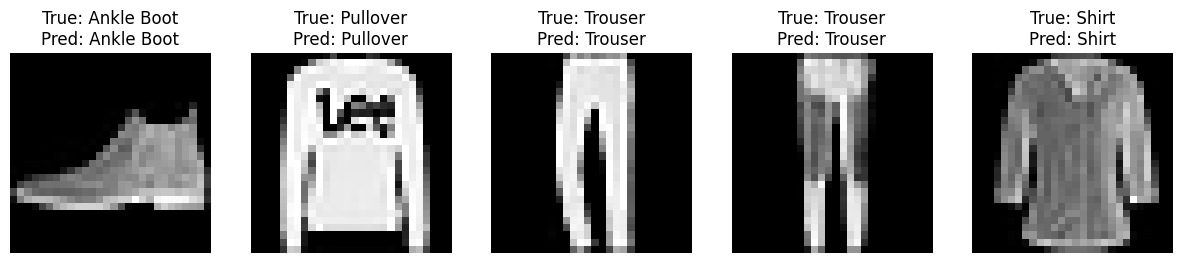

In [ ]:
import matplotlib.pyplot as plt

# визуализация предсказаний модели
def visualize_predictions(model, test_loader, num_images=5, labels_map=None):
    model.eval()  # переводим модель в режим оценки
    images, labels = next(iter(test_loader))  # получаем один батч изображений

    y_pred = model(images)
    _, preds = torch.max(y_pred, 1)

    if labels_map is not None:
        # преобразуем метки классов в понятные имена
        labels = [labels_map[l.item()] for l in labels]
        preds = [labels_map[p.item()] for p in preds]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 6))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f'True: {labels[i]}\nPred: {preds[i]}')
        ax.axis('off')
    plt.show()

visualize_predictions(model, test_loader, num_images=5, labels_map=labels_map)

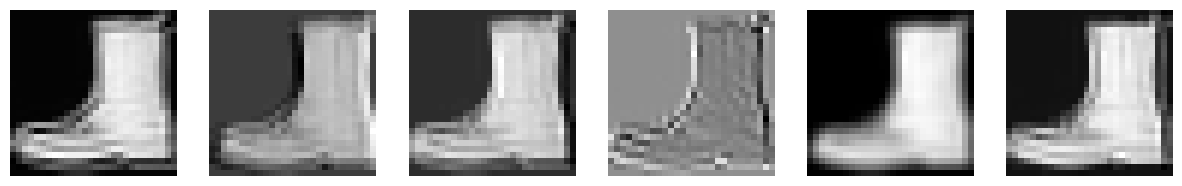

In [ ]:
def visualize_conv_filters(model, images):
    with torch.no_grad():
        conv1_out = model.conv1(images)
        fig, axes = plt.subplots(1, 6, figsize=(15, 15))
        for i in range(6):
            ax = axes[i]
            ax.imshow(conv1_out[0][i].cpu().numpy(), cmap='gray')
            ax.axis('off')
    plt.show()

# Возьмем батч данных из train_loader
images, _ = next(iter(train_loader))
visualize_conv_filters(model, images)


#### Сохранение модели

In [ ]:
torch.save(model.state_dict(), "CNNmodel_001.pth")
print("Saved PyTorch Model State to CNNmodel_001.pth")

Saved PyTorch Model State to CNNmodel_001.pth


In [ ]:
CNNmodel = CNNFashionMNIST()
CNNmodel.load_state_dict(torch.load("CNNmodel_001.pth"))

<ipython-input-43-ee1a48356787>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  CNNmodel.load_state_dict(torch.load("CNNmodel_001.pth"))


<All keys matched successfully>